# JJA_ts_teleconnection: Structure of Boreal Summer Surface Temperature Anomalies

The "JJA_ts_teleconnection" notebook evaluates the relationship between ENSO (El Niño-Southern Oscillation) and boreal summer surface temperature anomalies, focusing on the region between 60°S and 60°N. It analyses the spatial and temporal structure of surface temperature patterns during the JJA period, providing insights into teleconnections and their potential impacts on global climate variability. 
 
## Recommended Observational Datasets 

### Surface Temperature

- **ERA5 (1950-present)**: ERA5 is the fifth generation of global reanalysis data produced by ECMWF, providing high resolution hourly estimates of atmospheric, oceanic, and land-surface variables.
- **20CRv3 (1871-2019)**: The 20th Century Reanalysis provides global atmospheric data based on surface pressure observations and ensemble assimilation techniques, reconstructing weather patterns over the past 140 years.
- **NCEP2 (1979-2018)**: The second version of the NCEP reanalysis provides a range of atmospheric variables, including surface and upper-air data, and corrects issues in the original dataset, making it suitable for long-term climate and weather assessments.
- **ERA-Interim (1979-2018)**: Reanalysis data produced by the European Centre for Medium-Range Weather Forecasts (ECMWF), offering high-resolution atmospheric and surface variables using a global assimilation model.

## Dask Cluster  
Start a cluster with multiple cores

In [1]:
from dask.distributed import Client, progress
client = Client()
client

/g/data/xp65/public/apps/med_conda/envs/esmvaltool-0.6/lib/python3.11/site-packages/distributed/node.py:187: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 43173 instead
  warnings.warn(


Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /proxy/43173/status,
Dashboard: /proxy/43173/status,Workers: 7
Total threads: 14,Total memory: 63.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:39415,Workers: 7
Dashboard: /proxy/43173/status,Total threads: 14
Started: Just now,Total memory: 63.00 GiB
Comm: tcp://127.0.0.1:37767,Total threads: 2
Dashboard: /proxy/42325/status,Memory: 9.00 GiB
Nanny: tcp://127.0.0.1:44919,


## Datasets

In [1]:
from esmvalcore.dataset import Dataset
from esmvalcore.config import CFG
CFG['rootpath']['OBS6'].append(r'/g/data/kj13/datasets/esmvaltool/obsdata-v2') #NCEP-DOE-R2 tos

/g/data/xp65/public/apps/med_conda/envs/esmvaltool-0.8/lib/python3.11/site-packages/esmvalcore/config/_config_object.py:639: ESMValCoreDeprecationWarning: Usage of the single configuration file ~/.esmvaltool/config-user.yml or specifying it via CLI argument `--config_file` has been deprecated in ESMValCore version 2.12.0 and is scheduled for removal in version 2.14.0. Please run `mkdir -p ~/.config/esmvaltool && mv /home/189/fc6164/.esmvaltool/config-user.yml ~/.config/esmvaltool` (or alternatively use a custom `--config_dir`) and omit `--config_file`.
  config_obj.reload()
/g/data/xp65/public/apps/med_conda/envs/esmvaltool-0.8/lib/python3.11/site-packages/esmvalcore/config/_config_validators.py:405: ESMValCoreDeprecationWarning: The configuration option or command line argument `config_file` has been deprecated in ESMValCore version 2.12.0 and is scheduled for removal in version 2.14.0. Please use the option `config_dir` instead.
  _handle_deprecation(option, deprecated_version, remov

In [2]:
model_ts_datasets = {
"ACCESS-ESM1-5": 
    Dataset(
    short_name='ts',
    project='CMIP6',
    mip="Amon",
    exp="historical",
    ensemble="r1i1p1f1",
    timerange="19790101/20190101",
    dataset="ACCESS-ESM1-5",
    grid="gn"
)}

obs_ts_datasets = {
# "NOAA-CIRES-20CR-V2": 
#     Dataset(
#     short_name='ts',
#     dataset='NOAA-CIRES-20CR-V2',
#     mip="Amon",
#     project='OBS6',
#     type='reanaly',
#     timerange="187101/201212",
#     tier=2),
# "NCEP-DOE-R2": #nan data
#     Dataset(
#     short_name='tos',
#     dataset='NCEP-DOE-R2',
#     mip="Amon",
#     project='OBS6',
#     type='reanaly',
#     tier=2),
"ERA-Interim":
    Dataset(
    short_name='ts',
    dataset='ERA-Interim',
    mip="Amon",
    project='OBS6',
    type='reanaly',
    tier=3)
}

## Add Ancillary files 


In [3]:
for name, dataset in model_ts_datasets.items():
    dataset.add_supplementary(short_name='sftlf', mip="fx")
    dataset.add_supplementary(short_name="areacella", mip="fx")

In [4]:
model_ts_datasets = {name: dataset.load() for name, dataset in model_ts_datasets.items()}
obs_ts_datasets = {name: dataset.load() for name, dataset in obs_ts_datasets.items()}

/g/data/xp65/public/apps/med_conda/envs/esmvaltool-0.8/lib/python3.11/site-packages/esmvalcore/config/_config_validators.py:405: ESMValCoreDeprecationWarning: The configuration option or command line argument `config_file` has been deprecated in ESMValCore version 2.12.0 and is scheduled for removal in version 2.14.0. Please use the option `config_dir` instead.
  _handle_deprecation(option, deprecated_version, remove_version, more_info)
/g/data/xp65/public/apps/med_conda/envs/esmvaltool-0.8/lib/python3.11/site-packages/esmvalcore/config/_config_validators.py:405: ESMValCoreDeprecationWarning: The configuration option or command line argument `config_file` has been deprecated in ESMValCore version 2.12.0 and is scheduled for removal in version 2.14.0. Please use the option `config_dir` instead.
  _handle_deprecation(option, deprecated_version, remove_version, more_info)
/g/data/xp65/public/apps/med_conda/envs/esmvaltool-0.8/lib/python3.11/site-packages/esmvalcore/config/_config_validato

In [5]:
from esmvalcore.preprocessor import anomalies
from esmvalcore.preprocessor import area_statistics
from esmvalcore.preprocessor import seasonal_statistics
from esmvalcore.preprocessor import rolling_window_statistics
from esmvalcore.preprocessor import convert_units
from esmvalcore.preprocessor import extract_region
from esmvalcore.preprocessor import extract_season
from esmvalcore.preprocessor import extract_month
from esmvalcore.preprocessor import extract_time
from esmvalcore.preprocessor import detrend
from esmvalcore.preprocessor import regrid
from esmvalcore.preprocessor import detrend
from esmvalcore.preprocessor import mask_landsea
import iris

import matplotlib.pyplot as plt
import iris.quickplot as qplt
import numpy as np
import scipy.stats

In [6]:
def sst_enso(cube):
    nino34_latext_region = {"start_longitude": 190., "end_longitude": 240., "start_latitude": -5., "end_latitude": 5.}
    cube = extract_time(cube, start_year=1979, end_year=2014, start_month=1, end_month=12, start_day=1, end_day=31)

    cube = convert_units(cube, units="degC")
    cube = mask_landsea(cube, mask_out="land")
    cube = anomalies(cube, period="monthly")    
    cube = detrend(cube, dimension="time", method="linear")
    cube = extract_region(cube, **nino34_latext_region)
    cube = regrid(cube, target_grid="1x1", scheme="linear")  
    cube = area_statistics(cube,operator='mean')
    cube = extract_season(cube, season="JJA")
    cube = seasonal_statistics(cube, operator="mean", seasons=("JJA","SONDJFMAM"))
    return cube


def tsa_global(cube):
    region = {"start_longitude": 0., "end_longitude": 360., "start_latitude": -60., "end_latitude": 60.}
    cube = extract_time(cube, start_year=1979, end_year=2014, start_month=1, end_month=12, start_day=1, end_day=31)
    cube = convert_units(cube, units="degC")
    cube = anomalies(cube, period="monthly")
    cube = detrend(cube, dimension="time", method="linear")
    cube = extract_season(cube, season="JJA")
    cube = seasonal_statistics(cube, operator="mean", seasons=("JJA","SONDJFMAM"))
    cube = regrid(cube, target_grid="1x1", scheme="linear")
    cube = extract_region(cube, **region)
    return cube   

In [7]:
model_ts_datasets_prep = {name: sst_enso(dataset) for name, dataset in model_ts_datasets.items()}
model_glb_datasets_prep = {name: tsa_global(dataset) for name, dataset in model_ts_datasets.items()}

obs_ts_datasets_prep = {name: sst_enso(dataset) for name, dataset in obs_ts_datasets.items()}
obs_glb_datasets_prep = {name: tsa_global(dataset) for name, dataset in obs_ts_datasets.items()}

## Calculate Linear regression

In [8]:
def lin_regress_matrix(cubeA, cubeB): #array must not contain infs or NaNs
    """
    Calculate the linear regression of cubeA on cubeB using matrix operations.

    Parameters
    ----------
    cubeA: iris.cube.Cube
        The 2D input cube for which the regression is calculated.
    
    cubeB: iris.cube.Cube
        The cube used as the independent variable in the regression.

    Returns
    -------
    iris.cube.Cube
        A new cube containing the slope of the regression for each spatial point.
    """
    # Get data as flattened arrays
    A_data = cubeA.data.reshape(cubeA.shape[0], -1)  # Shape (time, spatial_points)
    B_data = cubeB.data.flatten()  # Shape (time,)

    # Add intercept term by stacking a column of ones with cubeB
    B_with_intercept = np.vstack([B_data, np.ones_like(B_data)]).T

    # Solve the linear equations using least squares method
    coefs, _, _, _ = np.linalg.lstsq(B_with_intercept, A_data, rcond=None)
    
    # Extract slopes from coefficients #coefs 1
    slopes = coefs[0].reshape(cubeA.shape[1], cubeA.shape[2])

    # Create a new Iris Cube for the regression results
    result_cube = iris.cube.Cube(slopes, long_name='regression ENSO SSTA',
                                 dim_coords_and_dims=[(cubeA.coord('latitude'), 0),
                                                      (cubeA.coord('longitude'), 1)])

    return result_cube

In [9]:
#create shapely geometry from lat/lon..
from shapely import box
import numpy as np
import shapely.vectorized as shp_vect

def get_sea_mask(cube_0time):
    region = {"start_longitude": 0., "end_longitude": 360., "start_latitude": -60., "end_latitude": 60.}
    cube = mask_landsea(cube_0time, mask_out="sea")
    cube = regrid(cube, target_grid="1x1", scheme="linear")
    cube = extract_region(cube, **region)
    return cube.data.mask
    
# Create a set of x,y points from the cube
def mask_pacific(cube, seamask):
    region = box(130.,-15.,290.,15)
    x_p, y_p = np.meshgrid(
        cube.coord(axis="X").points,
        cube.coord(axis="Y").points,
    )

    mask = shp_vect.contains(region, x_p, y_p)
    #add sea mask to get land
    mask = mask.astype(int) + seamask.astype(int)
    use_mask = np.zeros_like(mask, bool)
    use_mask[mask == 2] = True
    
    cube.data.mask = use_mask
    
    return cube

In [10]:
reg2_mod = lin_regress_matrix(model_glb_datasets_prep["ACCESS-ESM1-5"], model_ts_datasets_prep["ACCESS-ESM1-5"])
reg2_obs = lin_regress_matrix(obs_glb_datasets_prep["ERA-Interim"], obs_ts_datasets_prep["ERA-Interim"]) #

mod_seamask = get_sea_mask(model_ts_datasets["ACCESS-ESM1-5"][0])

reg2_obs_masked = mask_pacific(reg2_obs, mod_seamask)
reg2_mod_masked = mask_pacific(reg2_mod, mod_seamask)
process = {"ACCESS-ESM1-5":reg2_mod_masked , "ERA-Interim":reg2_obs_masked} 

In [11]:
print(obs_glb_datasets_prep["ERA-Interim"].data.min(), obs_ts_datasets_prep["ERA-Interim"].data.min())
print(model_glb_datasets_prep["ACCESS-ESM1-5"].data.min(), model_ts_datasets_prep["ACCESS-ESM1-5"].data.min())

-7.5553856 -1.5996774
-9.796574 -1.7826353


# Diagnostic Level 1

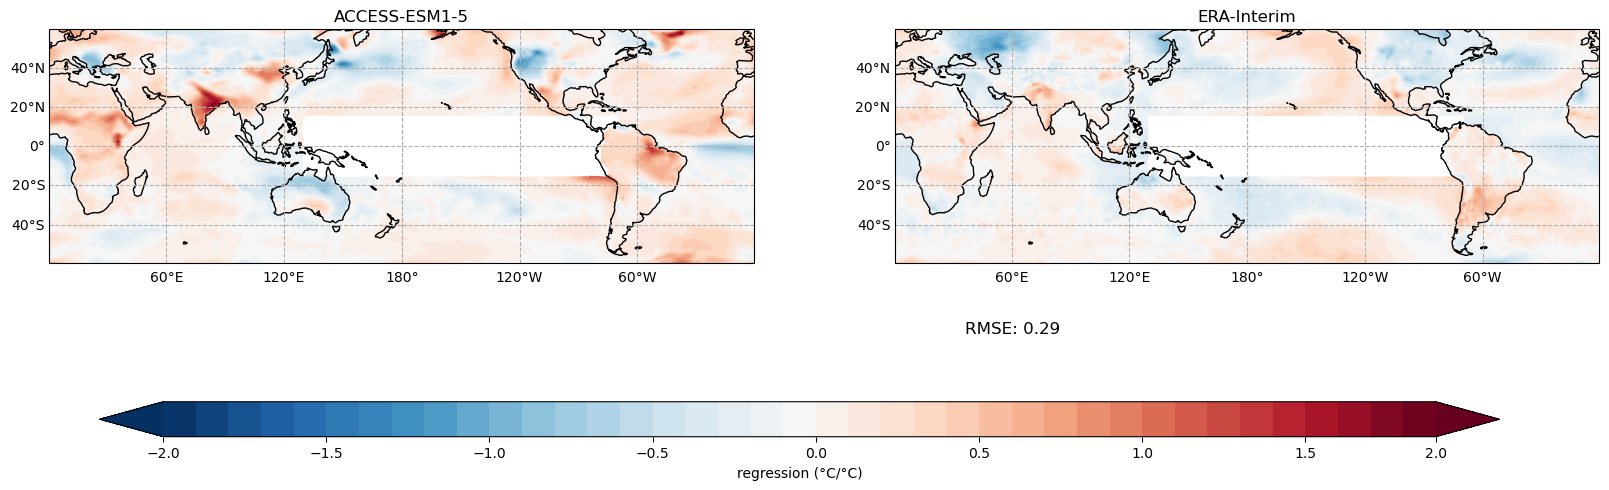

In [12]:
import iris.plot as iplt
import matplotlib.colors as mcolors
import cartopy.feature as cfeature
import cartopy.crs as ccrs

fig = plt.figure(figsize=(20, 7))
proj = ccrs.PlateCarree(central_longitude=180)

i =121

for label, cube in process.items():
    
    ax1 = plt.subplot(i,projection=proj)
    ax1.coastlines()
    cf1 = iplt.contourf(cube, levels=np.arange(-2,2,0.1), extend='both', cmap='RdBu_r')
    ax1.set_title(label)
    gl1 = ax1.gridlines(draw_labels=True, linestyle='--')
    gl1.top_labels = False
    gl1.right_labels = False
    i+=1

rmse = np.sqrt(np.mean((reg2_obs_masked.data- reg2_mod_masked.data) ** 2))

plt.text(0.1, -0.3, f'RMSE: {rmse:.2f} ', fontsize=12, ha='left',
         transform=plt.gca().transAxes, bbox=dict(facecolor='white', alpha=0.8, edgecolor='none'))

# Add a single colorbar at the bottom
cax = plt.axes([0.15,0.08,0.7,0.05])
cbar = fig.colorbar(cf1, cax=cax, orientation='horizontal', extend='both', ticks=np.arange(-2,2.5,0.5))
cbar.set_label('regression (°C/°C)')

This map shows the regression coefficients of global surface temperature anomalies (ts) on ENSO-related sea surface temperature anomalies (sst_enso), highlighting the influence of ENSO on regional temperature variability. A value of 0.5 indicates that a 1°C increase in ENSO-related SST corresponds to a 0.5°C increase in surface temperature in that area, reflecting a moderate response to ENSO. Positive values represent warming during El Niño events and cooling during La Niña, with the strength of the response varying by region. This visualisation illustrates how ENSO drives spatial patterns of global climate variability.



## Diagnostics level 2   


In [13]:
from esmvalcore.preprocessor import mask_above_threshold
from esmvalcore.preprocessor import mask_below_threshold
from esmvalcore.preprocessor import rolling_window_statistics
from esmvalcore.preprocessor import extract_month
from esmvalcore.preprocessor import extract_time
import numpy as np

def nino3_4ssta(cube):
    cube = extract_region(cube, 150, 270, -5, 5)
    cube = extract_time(cube, start_year=1979, end_year=2014, start_month=1, end_month=12, start_day=1, end_day=31)
    cube = anomalies(cube, period='monthly')    
    # triangle weighted- double smoothed
    cube = rolling_window_statistics(cube, coordinate='time', operator='mean', window_length=5)
    # cube = rolling_window_statistics(cube, coordinate='time', operator='mean', window_length=5)
    cube = area_statistics(cube, 'mean')
    cube = extract_month(cube, 12)

    return cube
    
def mask_to_years(events):
    maskedTime = np.ma.masked_array(events.coord('time').points, mask=events.data.mask)
    return [events.coord('time').units.num2date(time).year for time in maskedTime.compressed()]
    
def enso_events(cube):
    std = cube.data.std()
    a_events = mask_to_years(mask_above_threshold(cube.copy(), -0.75 * std))
    o_events = mask_to_years(mask_below_threshold(cube.copy(), 0.75 * std))
    return {'nina':a_events, 'nino':o_events}

In [17]:
prep_datasets = {"ACCESS-ESM1-5":[model_glb_datasets_prep["ACCESS-ESM1-5"], model_ts_datasets_prep["ACCESS-ESM1-5"]],
                    "ERA-Interim":[obs_glb_datasets_prep["ERA-Interim"], obs_ts_datasets_prep["ERA-Interim"]]}
ts_datasets = {**model_ts_datasets,
               **obs_ts_datasets}

In [18]:
events_dict = {}
for name, ds in ts_datasets.items():
    nino_res = nino3_4ssta(ds)
    events_dict[name] = enso_events(nino_res) #for each ds

cubes_dict_nina = {}
cubes_dict_nino = {}
for ds_name, events in events_dict.items():
    print(ds_name)
    for enso, years in events.items():
        print(enso, len(years), 'number of event years')
        year_enso = iris.Constraint(time=lambda cell: cell.point.year in years)
        cube_glb = prep_datasets[ds_name][0].extract(year_enso)
        cube_ts = prep_datasets[ds_name][1].extract(year_enso)
        
        if enso == 'nina': ## plot separate
            cubes_dict_nina[ds_name] = [cube_glb, cube_ts]
        else:
            cubes_dict_nino[ds_name] = [cube_glb, cube_ts]

print(events_dict)

/g/data/xp65/public/apps/med_conda/envs/esmvaltool-0.8/lib/python3.11/site-packages/iris/cube.py:4896: IrisIgnoringBoundsWarning: The bounds of coordinate 'time' were ignored in the rolling window operation.
  warnings.warn(
/g/data/xp65/public/apps/med_conda/envs/esmvaltool-0.8/lib/python3.11/site-packages/iris/cube.py:4896: IrisIgnoringBoundsWarning: The bounds of coordinate 'time' were ignored in the rolling window operation.
  warnings.warn(


ACCESS-ESM1-5
nina 9 number of event years
nino 10 number of event years
ERA-Interim
nina 7 number of event years
nino 9 number of event years
{'ACCESS-ESM1-5': {'nina': [1981, 1984, 1985, 1987, 1990, 1993, 1994, 1999, 2006], 'nino': [1983, 1995, 1997, 1998, 2001, 2004, 2008, 2010, 2012, 2013]}, 'ERA-Interim': {'nina': [1984, 1988, 1998, 1999, 2007, 2010, 2011], 'nino': [1982, 1986, 1987, 1991, 1994, 1997, 2002, 2006, 2009]}}


In [19]:
process = {} # mask..

# rmse = np.sqrt(np.mean((reg2_obs.data- reg2_mod.data) ** 2))

for key, cubes in cubes_dict_nina.items():
    reg_cube = lin_regress_matrix(cubes[0], cubes[1])
    process[f'{key} la nina'] = mask_pacific(reg_cube, mod_seamask)
    
#rmse ..in plotting.. when even
for key, cubes in cubes_dict_nino.items():
    reg_cube = lin_regress_matrix(cubes[0], cubes[1])
    process[f'{key} el nino'] = mask_pacific(reg_cube, mod_seamask)

print(np.sqrt(np.mean((process['ERA-Interim la nina'].data - process['ACCESS-ESM1-5 la nina'].data) ** 2)))

0.7963844621014221


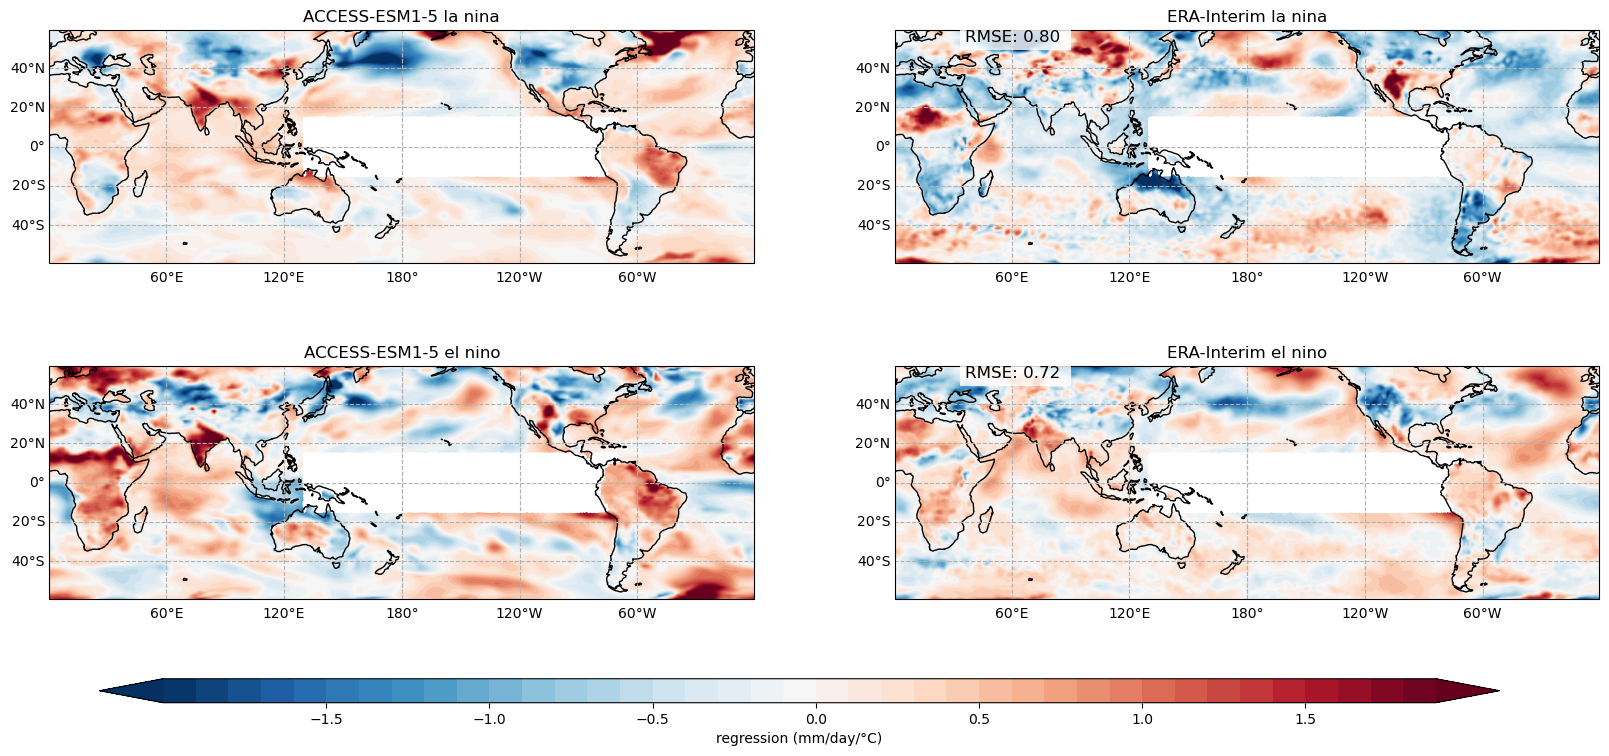

In [20]:
fig = plt.figure(figsize=(20, 8)) #func? params - process, rmse
proj = ccrs.PlateCarree(central_longitude=180)

i =221
for label, cube in process.items(): #j for 2 rows 
    
    ax1 = plt.subplot(i,projection=proj)
    ax1.coastlines()
    cf1 = iplt.contourf(cube, levels=np.arange(-2.,2.,0.1), extend='both', cmap='RdBu_r')
    ax1.set_title(label)
    gl1 = ax1.gridlines(draw_labels=True, linestyle='--')
    gl1.top_labels = False
    gl1.right_labels = False
    
    if i%2 == 0: #model first, odd, prev
        rmse = np.sqrt(np.mean((cube.data- cube_prev.data) ** 2))
        plt.text(0.1, 0.95, f'RMSE: {rmse:.2f} ', fontsize=12, ha='left',
         transform=plt.gca().transAxes, bbox=dict(facecolor='white', alpha=0.8, edgecolor='none'))
    i+=1
    cube_prev = cube
    

cax = plt.axes([0.15,0.01,0.7,0.03])
cbar = fig.colorbar(cf1, cax=cax, orientation='horizontal', extend='both', ticks=np.arange(-1.5,1.8,0.5))
cbar.set_label('regression (mm/day/°C)')